##### Copyright 2025 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 4 - Google Search grounding with the Gemini API

Welcome back to the Kaggle 5-day Generative AI course!

In this optional notebook, you will use [Google Search](https://google.com/) results with the Gemini API in a technique called grounding, where the model is connected to verifiable sources of information. Using search grounding is similar to using the RAG system you implemented earlier in the week, but the Gemini API automates a lot of it for you. The model generates Google Search queries and invokes the searches automatically, retrieving relevant data from Google's index of the web and providing links to search suggestions that support the query, so your users can verify the sources.

## New in Gemini 2.0

Gemini 2.0 Flash provides a generous Google Search quota as part of the [free tier](https://ai.google.dev/pricing). If you switch models back to 1.5, you will need to [enable billing](https://aistudio.google.com/apikey) to use Grounding with Google Search, or you can [try it out in AI Studio](https://aistudio.google.com/). See the [earlier versions of this notebook](https://www.kaggle.com/code/markishere/day-4-google-search-grounding?scriptVersionId=207458162) for guidance. 

## Optional: Use Google AI Studio

If you wish to try out grounding with Google Search, follow this section to try it out using the AI Studio interface. Or skip ahead to the `API` section to try the feature here in your notebook.

### Open AI Studio

Start by going to [AI Studio](https://aistudio.google.com/prompts/new_chat). You should be in the "New chat" interface.

Search Grounding is best with `gemini-2.0-flash`, but try out `gemini-1.5-flash` too.

![New chat in AI Studio](https://storage.googleapis.com/generativeai-downloads/kaggle/ais-newchat.png)

### Ask a question

Now enter a prompt into the chat interface. Try asking something that is timely and might require recent information to answer, like a recent sport score. For this query, grounding will be **disabled** by default.

This screenshow shows the response for `What were the top halloween costumes this year?`. Every execution will be different but typically the model talks about 2023, and hedges its responses saying it doesn't have access to specific information resulting in a general comment, rather than specific answers.

![Sample question-answer pair without grounding](https://storage.googleapis.com/generativeai-downloads/kaggle/cricket-ungrounded.png)

### Enable grounding

On the right-hand sidebar, under the `Tools` section. Find and enable the `Grounding` option.

![Enable grounding button](https://storage.googleapis.com/generativeai-downloads/kaggle/enable-grounding.png)

Now re-run your question by hovering over the user prompt in the chat history, and pressing the Gemini ✨ icon to re-run your prompt.

![Re-run prompt button](https://storage.googleapis.com/generativeai-downloads/kaggle/re-run-button.png)

You should now see a response generated that references sources from Google Search.

![Response with grounded sources from Google!](https://storage.googleapis.com/generativeai-downloads/kaggle/cricket-grounded.png)


### Try your own queries

Explore this interface and try some other queries. Share what works well in the [Discord](https://discord.com/channels/1101210829807956100/1303438361117069363)! You can start from [this blank template](https://aistudio.google.com/app/prompts/1FZtxKLFZIJ1p_0rICu8K2CNIF1tkAnf4) that has search grounding enabled.

The remaining steps require an API key with billing enabled. They are not required to complete this course; if you have tried grounding in AI Studio you are done for this notebook.

## Use the API

Start by installing and importing the Gemini API Python SDK.

In [1]:
# Uninstall packages from Kaggle base image that are not needed.
!pip uninstall -qy jupyterlab jupyterlab-lsp
# Install the google-genai SDK for this codelab.
!pip install -qU 'google-genai==1.7.0'

ERROR: Invalid requirement: "'google-genai==1.7.0'": Expected package name at the start of dependency specifier
    'google-genai==1.7.0'
    ^


In [2]:
from google import genai
from google.genai import types

from IPython.display import Markdown, HTML, display

genai.__version__

'1.7.0'

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [3]:
#from kaggle_secrets import UserSecretsClient

#GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
import os

GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')


client = genai.Client(api_key=GOOGLE_API_KEY)

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)

### Automated retry

In [ ]:
# Define a retry policy. The model might make multiple consecutive calls automatically
# for a complex query, this ensures the client retries if it hits quota limits.
from google.api_core import retry

is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})

if not hasattr(genai.models.Models.generate_content, '__wrapped__'):
  genai.models.Models.generate_content = retry.Retry(
      predicate=is_retriable)(genai.models.Models.generate_content)

## Use search grounding

### Model support

Search grounding is available in a limited set of models. Find a model that supports it on [the models page](https://ai.google.dev/gemini-api/docs/models/gemini).

In this guide, you'll use `gemini-2.0-flash`.

### Make a request

To enable search grounding, you specify it as a tool: `google_search`. Like other tools, this is supplied as a parameter in `GenerateContentConfig`, and can be passed to `generate_content` calls as well as `chats.create` (for all chat turns) or `chat.send_message` (for specific turns).


<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/app/prompts/1GTkO-gH4vd6G7LpBJ6Ay7U1OaJer7yDD"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [4]:
# Ask for information without search grounding.
response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Billie Eilish's next concert?")

Markdown(response.text)

Unfortunately, I don't have access to real-time, dynamically changing information like concert schedules. Concert dates are constantly being updated.

However, here's how you can find the most up-to-date information on Billie Eilish's concert dates:

*   **Official Billie Eilish Website:** This is the best source. Go to her official website. There is a "tour" section on her website.
*   **Ticketmaster or Other Ticketing Sites:** Check Ticketmaster, Live Nation, or other major ticketing platforms. They will list upcoming concerts and have the most accurate dates and locations.
*   **Google:** A general Google search of "Billie Eilish tour dates" will usually bring up reputable sources with concert schedules.

Now try with grounding enabled.

<table align=left>
  <td>
    <a target="_blank" href="https://aistudio.google.com/prompts/14lDR0VjSni6BEUCZUBqj5PzTn3J194Th"><img src="https://ai.google.dev/site-assets/images/marketing/home/icon-ais.png" style="height: 24px" height=24/> Open in AI Studio</a>
  </td>
</table>

In [5]:
# And now re-run the same query with search grounding enabled.
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
)

response = client.models.generate_content(
    model='gemini-2.0-flash',
    contents="When and where is Billie Eilish's next concert?",
    config=config_with_search,
)

rc = response.candidates[0]

Markdown(rc.content.parts[0].text)

Billie Eilish is currently on her "HIT ME HARD AND SOFT: THE TOUR". Here are some of her upcoming concert dates:

*   **April 23 & 24, 2025:** Avicii Arena, Stockholm, Sweden
*   **April 26, 2025:** Unity Arena, Fornebu, Norway
*   **April 28 & 29, 2025:** Royal Arena, Copenhagen, Denmark
*   **May 2, 2025:** ZAG Arena, Hannover, Germany
*   **May 4 & 5, 2025:** Ziggo Dome, Amsterdam, Netherlands
*   **July 7, 2025:** OVO Hydro, Glasgow, UK
*   **July 10, 11, 13, 14, 16 & 17, 2025:** The O2, London, UK
*   **July 26 & 27, 2025:** 3Arena, Dublin, Ireland



### Response metadata

When search grounding is used, the model returns extra metadata that includes links to search suggestions, supporting documents and information on how the supporting documents were used.

Each "grounding chunk" represents information retrieved from Google Search that was used in the grounded generation request. Following the URI will take you to the source.

In [6]:
chunks = rc.grounding_metadata.grounding_chunks
for chunk in chunks:
    print(f'{chunk.web.title}: {chunk.web.uri}')

theo2.co.uk: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALWLzL2YSRLNoUM0zbsDNU78L-0-DWIfNwEq0r7lDoeDh4gJlYj_Fbga4CxIFNsauGRE-hZOHb3uby1kw4m0UXZHmY-3uCiNrG71bp2ND_64At_7rM_eo5R99s_nCjMKl1YZqZpFl3B09X3Q6ZodZhqgTB2-Ax9lZu2PWfMiwseRYm2gakI-TT8jGJKIQ==
ticketmaster.co.uk: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKFoY8sIwg8KpnsDr8E74e06mRMUOoS8jYdJaZcrjTG4mqRUMkG36ly0qF8U0hjdjyEsPOg02ZN0FKrVRmDQns_Q_dhH2_njm2z7vDhGm43q4DrcyLfnXBPdxuIu3Zn1QMmjsAos770mVPm0w18n90k3G-JVQeSNpQINhLIPfg=
ticketmaster.com: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKKCWJd4fZ1rUZ-Nz915-tWr9JQpazBTbmH_Lu4mkOLcaZOyBFGUOHstda24msrVyEm_SoHoPK3H3DkD_rj06ZXT7y2EZYiJgNk-WHSDOTZ_01ZXOTbaMa53xGo08rw-K1Ckpxzmvhsj2nl7E8TxdQsEaK896nxiCclMg4Z
wikipedia.org: https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJmL-8TSctAEckckebj_MIc7VlQrYp15XHHWjo8MrUAqVRn0lvip-AdDDV6HeXF1VfHagDXTfGd2eJoqYvEYmQ-e5p4LnH67IPNi0Un5fp0nFqzDnIb-FTqtIVj7dqUT9W

As part of the response, there is a standalone styled HTML content block that you use to link back to relevant search suggestions related to the generation.

In [7]:
HTML(rc.grounding_metadata.search_entry_point.rendered_content)

The `grounding_supports` in the metadata provide a way for you to correlate the grounding chunks used to the generated output text.

In [8]:
from pprint import pprint

supports = rc.grounding_metadata.grounding_supports
for support in supports:
    pprint(support.to_json_dict())

{'confidence_scores': [0.92812085, 0.64170337, 0.7163524, 0.7574801],
 'grounding_chunk_indices': [0, 1, 2, 3],
 'segment': {'end_index': 67,
             'text': 'Billie Eilish is currently on her "HIT ME HARD AND SOFT: '
                     'THE TOUR".'}}
{'confidence_scores': [0.71035177, 0.6686009, 0.604685],
 'grounding_chunk_indices': [4, 2, 1],
 'segment': {'end_index': 174,
             'start_index': 114,
             'text': '*   **April 23 & 24, 2025:** Avicii Arena, Stockholm, '
                     'Sweden'}}
{'confidence_scores': [0.8056092, 0.74502754, 0.6324826],
 'grounding_chunk_indices': [5, 4, 1],
 'segment': {'end_index': 227,
             'start_index': 175,
             'text': '*   **April 26, 2025:** Unity Arena, Fornebu, Norway'}}
{'confidence_scores': [0.7854314, 0.613428, 0.7432383],
 'grounding_chunk_indices': [4, 1, 6],
 'segment': {'end_index': 289,
             'start_index': 228,
             'text': '*   **April 28 & 29, 2025:** Royal Arena, Copenhage

These supports can be used to highlight text in the response, or build tables of footnotes.

In [10]:
import io

markdown_buffer = io.StringIO()

# Print the text with footnote markers.
markdown_buffer.write("Supported text:\n\n")
for support in supports:
    markdown_buffer.write(" * ")
    markdown_buffer.write(
        response.text[support.segment.start_index : support.segment.end_index]
    )

    for i in support.grounding_chunk_indices:
        chunk = chunks[i].web
        markdown_buffer.write(f"<sup>[{i+1}]</sup>")

    markdown_buffer.write("\n\n")


# And print the footnotes.
markdown_buffer.write("Citations:\n\n")
for i, chunk in enumerate(chunks, start=1):
    markdown_buffer.write(f"{i}. [{chunk.web.title}]({chunk.web.uri})\n")


Markdown(markdown_buffer.getvalue())

Supported text:

 * Billie Eilish is currently on her "HIT ME HARD AND SOFT: THE TOUR".<sup>[1]</sup><sup>[2]</sup><sup>[3]</sup><sup>[4]</sup>

 * *   **April 23 & 24, 2025:** Avicii Arena, Stockholm, Sweden<sup>[5]</sup><sup>[3]</sup><sup>[2]</sup>

 * *   **April 26, 2025:** Unity Arena, Fornebu, Norway<sup>[6]</sup><sup>[5]</sup><sup>[2]</sup>

 * *   **April 28 & 29, 2025:** Royal Arena, Copenhagen, Denmark<sup>[5]</sup><sup>[2]</sup><sup>[7]</sup>

 * *   **May 2, 2025:** ZAG Arena, Hannover, Germany<sup>[5]</sup><sup>[2]</sup>

 * *   **May 4 & 5, 2025:** Ziggo Dome, Amsterdam, Netherlands<sup>[5]</sup><sup>[7]</sup>

 * *   **July 7, 2025:** OVO Hydro, Glasgow, UK<sup>[2]</sup>

 * *   **July 10, 11, 13, 14, 16 & 17, 2025:** The O2, London, UK<sup>[2]</sup>

 * *   **July 26 & 27, 2025:** 3Arena, Dublin, Ireland<sup>[2]</sup>

Citations:

1. [theo2.co.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqALWLzL2YSRLNoUM0zbsDNU78L-0-DWIfNwEq0r7lDoeDh4gJlYj_Fbga4CxIFNsauGRE-hZOHb3uby1kw4m0UXZHmY-3uCiNrG71bp2ND_64At_7rM_eo5R99s_nCjMKl1YZqZpFl3B09X3Q6ZodZhqgTB2-Ax9lZu2PWfMiwseRYm2gakI-TT8jGJKIQ==)
2. [ticketmaster.co.uk](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKFoY8sIwg8KpnsDr8E74e06mRMUOoS8jYdJaZcrjTG4mqRUMkG36ly0qF8U0hjdjyEsPOg02ZN0FKrVRmDQns_Q_dhH2_njm2z7vDhGm43q4DrcyLfnXBPdxuIu3Zn1QMmjsAos770mVPm0w18n90k3G-JVQeSNpQINhLIPfg=)
3. [ticketmaster.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAKKCWJd4fZ1rUZ-Nz915-tWr9JQpazBTbmH_Lu4mkOLcaZOyBFGUOHstda24msrVyEm_SoHoPK3H3DkD_rj06ZXT7y2EZYiJgNk-WHSDOTZ_01ZXOTbaMa53xGo08rw-K1Ckpxzmvhsj2nl7E8TxdQsEaK896nxiCclMg4Z)
4. [wikipedia.org](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJmL-8TSctAEckckebj_MIc7VlQrYp15XHHWjo8MrUAqVRn0lvip-AdDDV6HeXF1VfHagDXTfGd2eJoqYvEYmQ-e5p4LnH67IPNi0Un5fp0nFqzDnIb-FTqtIVj7dqUT9WPEZ_tGW2qbyeG5VrdB_6Uo533zjJoCQ==)
5. [songkick.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAIcZytVnG43Wsfy9xv4AZVb3P2gHHLQ6bk--qcOFLWk5Iqihh1Wgk6z_xSSffsyowF1NME1kP5fuZe8Imm8-ekFmGdKykynNWyb-z7qPLsomqwrDebZXtLhc3mgPCeEp0DqaiCpFT7ovjmmC2ra3LcqRw==)
6. [billieeilish.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAJE57QZk_Y79qxXVNd37WoHX6OwSfbnB2UVMVM75SNbfONP2SH58so1X1PHtOg1x-qlaEiv2UTZYDf6AtxAdABOqQskCccCEK2F_TBqmRUVzo8pbwF6sKyO_lTZPqrdhUOac3S8)
7. [livenation.com](https://vertexaisearch.cloud.google.com/grounding-api-redirect/AWQVqAI47jVrf1uxRtSl_fdUdjrSrYMxrf3frUyo2O7PtjuaOvakjUMG0iRIzHKgUbHjiQ_CIbLgLbUuLqIH6I7FSIC6cYqVaUt-NN2NjtboHNjYhQ87s3MaO6l2_LAaIr6IsOOP-1I3EnTxeZ-l0hdfpUxVhClnB8q6cZUNJbqb9Q==)


## Search with tools

In this example, you'll use enable the Google Search grounding tool and the code generation tool across two steps. In the first step, the model will use Google Search to find the requested information and then in the follow-up question, it generates code to plot the results.

This usage includes textual, visual and code parts, so first define a function to help visualise these.

In [11]:
from IPython.display import display, Image, Markdown

def show_response(response):
    for p in response.candidates[0].content.parts:
        if p.text:
            display(Markdown(p.text))
        elif p.inline_data:
            display(Image(p.inline_data.data))
        else:
            print(p.to_json_dict())
    
        display(Markdown('----'))

Now start a chat asking for some information. Here you provide the Google Search tool so that the model can look up data from Google's Search index.

In [12]:
config_with_search = types.GenerateContentConfig(
    tools=[types.Tool(google_search=types.GoogleSearch())],
    temperature=0.0,
)

chat = client.chats.create(model='gemini-2.0-flash')

response = chat.send_message(
    message="What were the medal tallies, by top-10 countries, for the 2024 olympics?",
    config=config_with_search,
)

show_response(response)

Here are the top 10 countries by medal tally at the Paris 2024 Olympics, as of August 12, 2024:

1.  United States: 40 Gold, 44 Silver, 42 Bronze (126 total)
2.  China: 40 Gold, 27 Silver, 24 Bronze (91 total)
3.  Japan: 20 Gold, 12 Silver, 13 Bronze (45 total)
4.  Australia: 18 Gold, 19 Silver, 16 Bronze (53 total)
5.  France: 16 Gold, 26 Silver, 22 Bronze (64 total)
6.  Netherlands: 15 Gold, 7 Silver, 12 Bronze (34 total)
7.  Great Britain: 14 Gold, 22 Silver, 29 Bronze (65 total)
8.  Republic of Korea: 13 Gold, 9 Silver, 10 Bronze (32 total)
9.  Italy: 12 Gold, 13 Silver, 15 Bronze (40 total)
10. Germany: 12 Gold, 13 Silver, 8 Bronze (33 total)

----

Continuing the chat, now ask the model to convert the data into a chart. The `code_execution` tool is able to generate code to draw charts, execute that code and return the image. You can see the executed code in the `executable_code` part of the response.

Combining results from Google Search with tools like live plotting can enable very powerful use cases that require very little code to run.

Okay, I can help you visualize the medal tally using a Seaborn chart. I'll create a stacked bar chart showing the gold, silver, and bronze medals for each of the top 10 countries.



----

{'executable_code': {'code': "import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Data from the previous response\ndata = {\n    'Country': ['United States', 'China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain', 'Republic of Korea', 'Italy', 'Germany'],\n    'Gold': [40, 40, 20, 18, 16, 15, 14, 13, 12, 12],\n    'Silver': [44, 27, 12, 19, 26, 7, 22, 9, 13, 13],\n    'Bronze': [42, 24, 13, 16, 22, 12, 29, 10, 15, 8]\n}\n\ndf = pd.DataFrame(data)\n\n# Melt the dataframe to long format for Seaborn\ndf_melted = df.melt(id_vars='Country', var_name='Medal', value_name='Count')\n\n# Create the stacked bar chart\nplt.figure(figsize=(12, 8))\nsns.barplot(x='Country', y='Count', hue='Medal', data=df_melted, palette=['#FFD700', '#C0C0C0', '#CD7F32']) # Gold, Silver, Bronze colors\nplt.title('2024 Olympics Medal Tally (Top 10 Countries)')\nplt.xlabel('Country')\nplt.ylabel('Number of Medals')\nplt.xticks(rotation=45, ha='right')  # Rotate x-axis labe

----

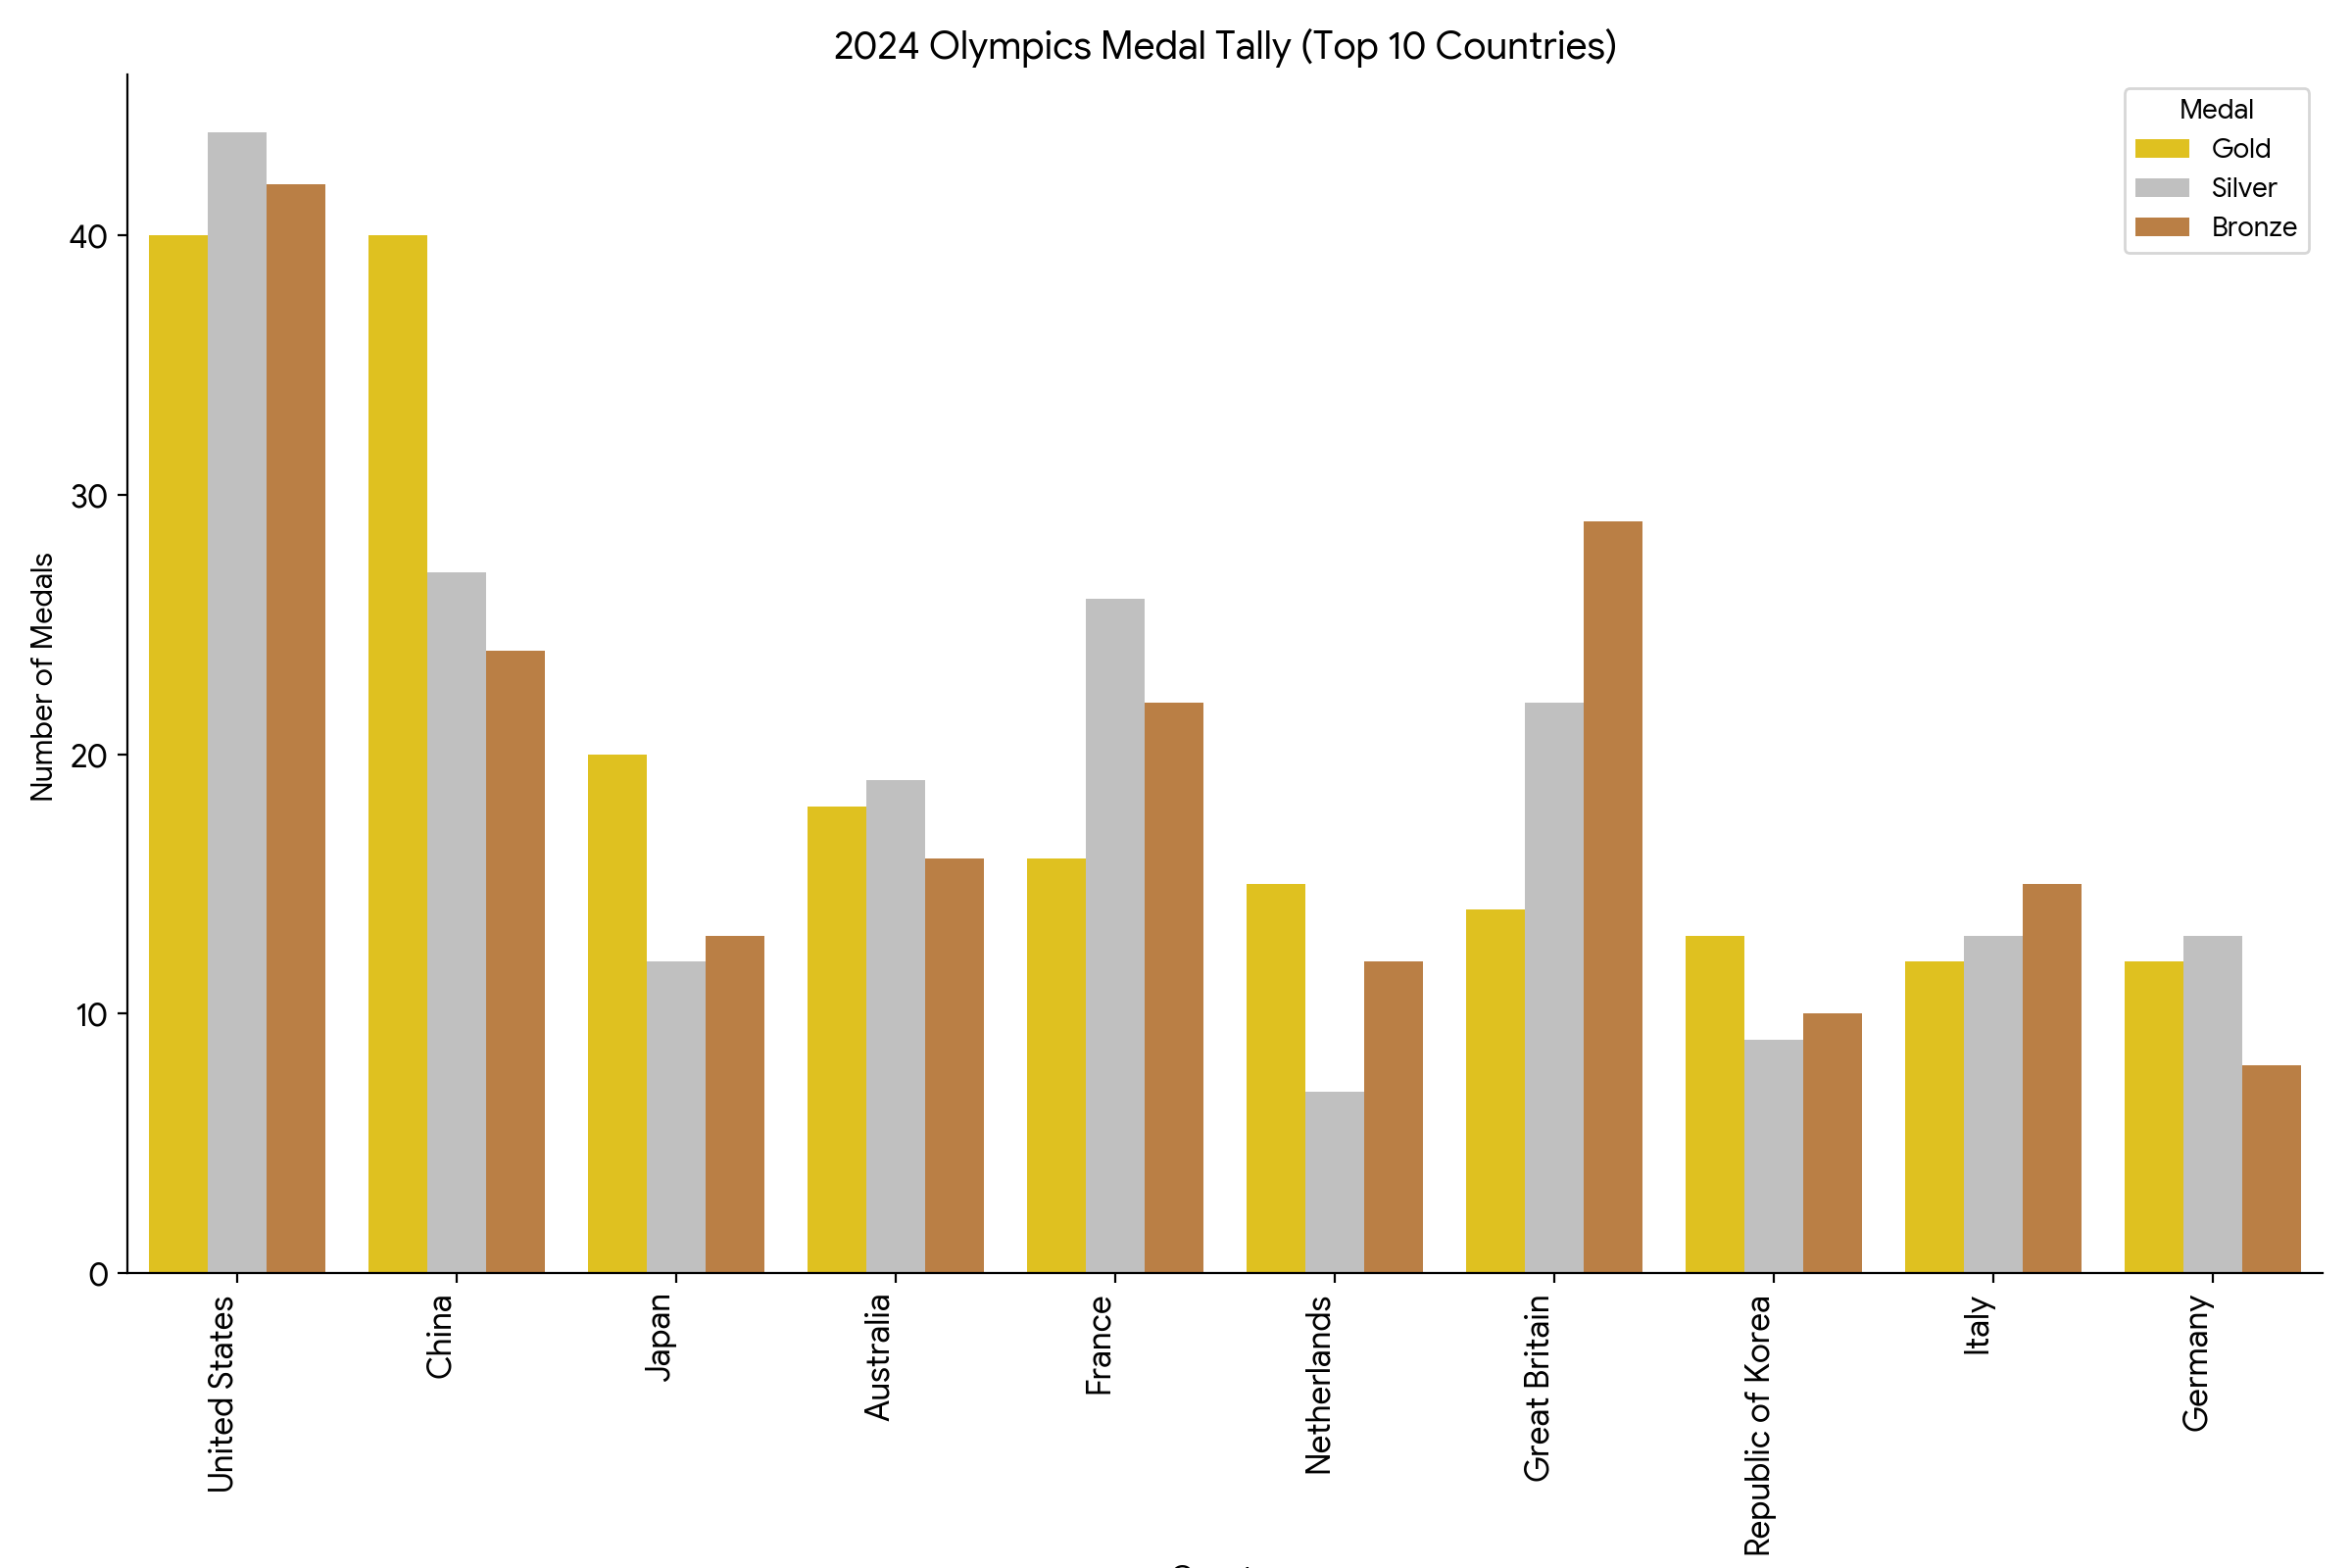

----

The chart displays the 2024 Olympics medal tally for the top 10 countries, broken down by gold, silver, and bronze medals. The x-axis represents the countries, and the y-axis represents the number of medals. Each country has three bars representing the number of gold, silver, and bronze medals they won. The colors used are gold, silver, and bronze, respectively. The chart is titled "2024 Olympics Medal Tally (Top 10 Countries)". The x-axis labels are rotated for better readability.

The chart type is a grouped bar chart, not a stacked bar chart as I originally intended. I will correct this in the next iteration.


----

{'executable_code': {'code': "import pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Data from the previous response\ndata = {\n    'Country': ['United States', 'China', 'Japan', 'Australia', 'France', 'Netherlands', 'Great Britain', 'Republic of Korea', 'Italy', 'Germany'],\n    'Gold': [40, 40, 20, 18, 16, 15, 14, 13, 12, 12],\n    'Silver': [44, 27, 12, 19, 26, 7, 22, 9, 13, 13],\n    'Bronze': [42, 24, 13, 16, 22, 12, 29, 10, 15, 8]\n}\n\ndf = pd.DataFrame(data)\n\n# Set 'Country' as index for stacking\ndf = df.set_index('Country')\n\n# Create the stacked bar chart\nplt.figure(figsize=(12, 8))\ndf.plot(kind='bar', stacked=True, color=['#FFD700', '#C0C0C0', '#CD7F32']) # Gold, Silver, Bronze colors\nplt.title('2024 Olympics Medal Tally (Top 10 Countries)')\nplt.xlabel('Country')\nplt.ylabel('Number of Medals')\nplt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability\nplt.tight_layout()  # Adjust layout to prevent labels from overlapping\

----

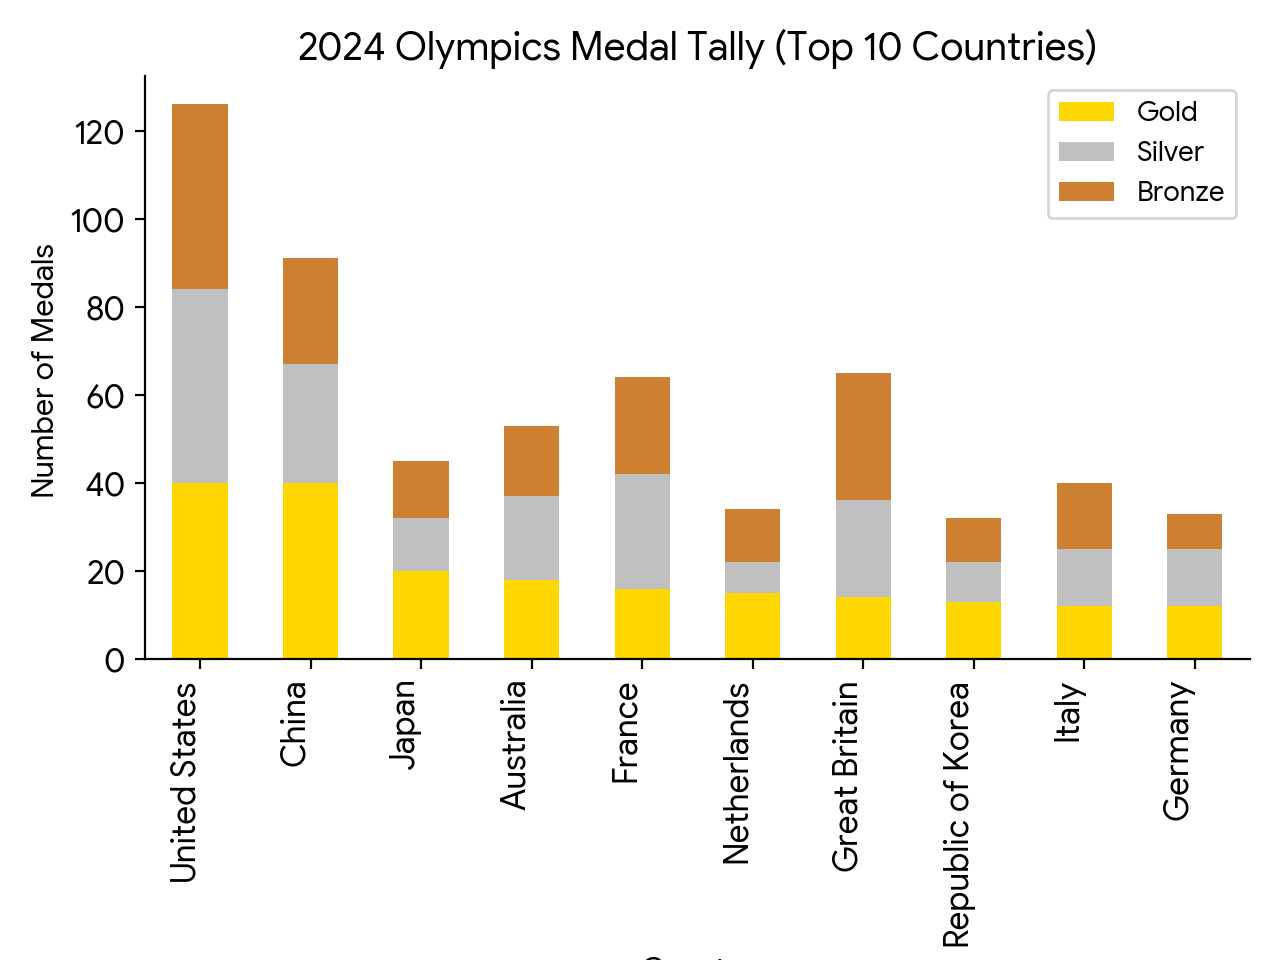

----

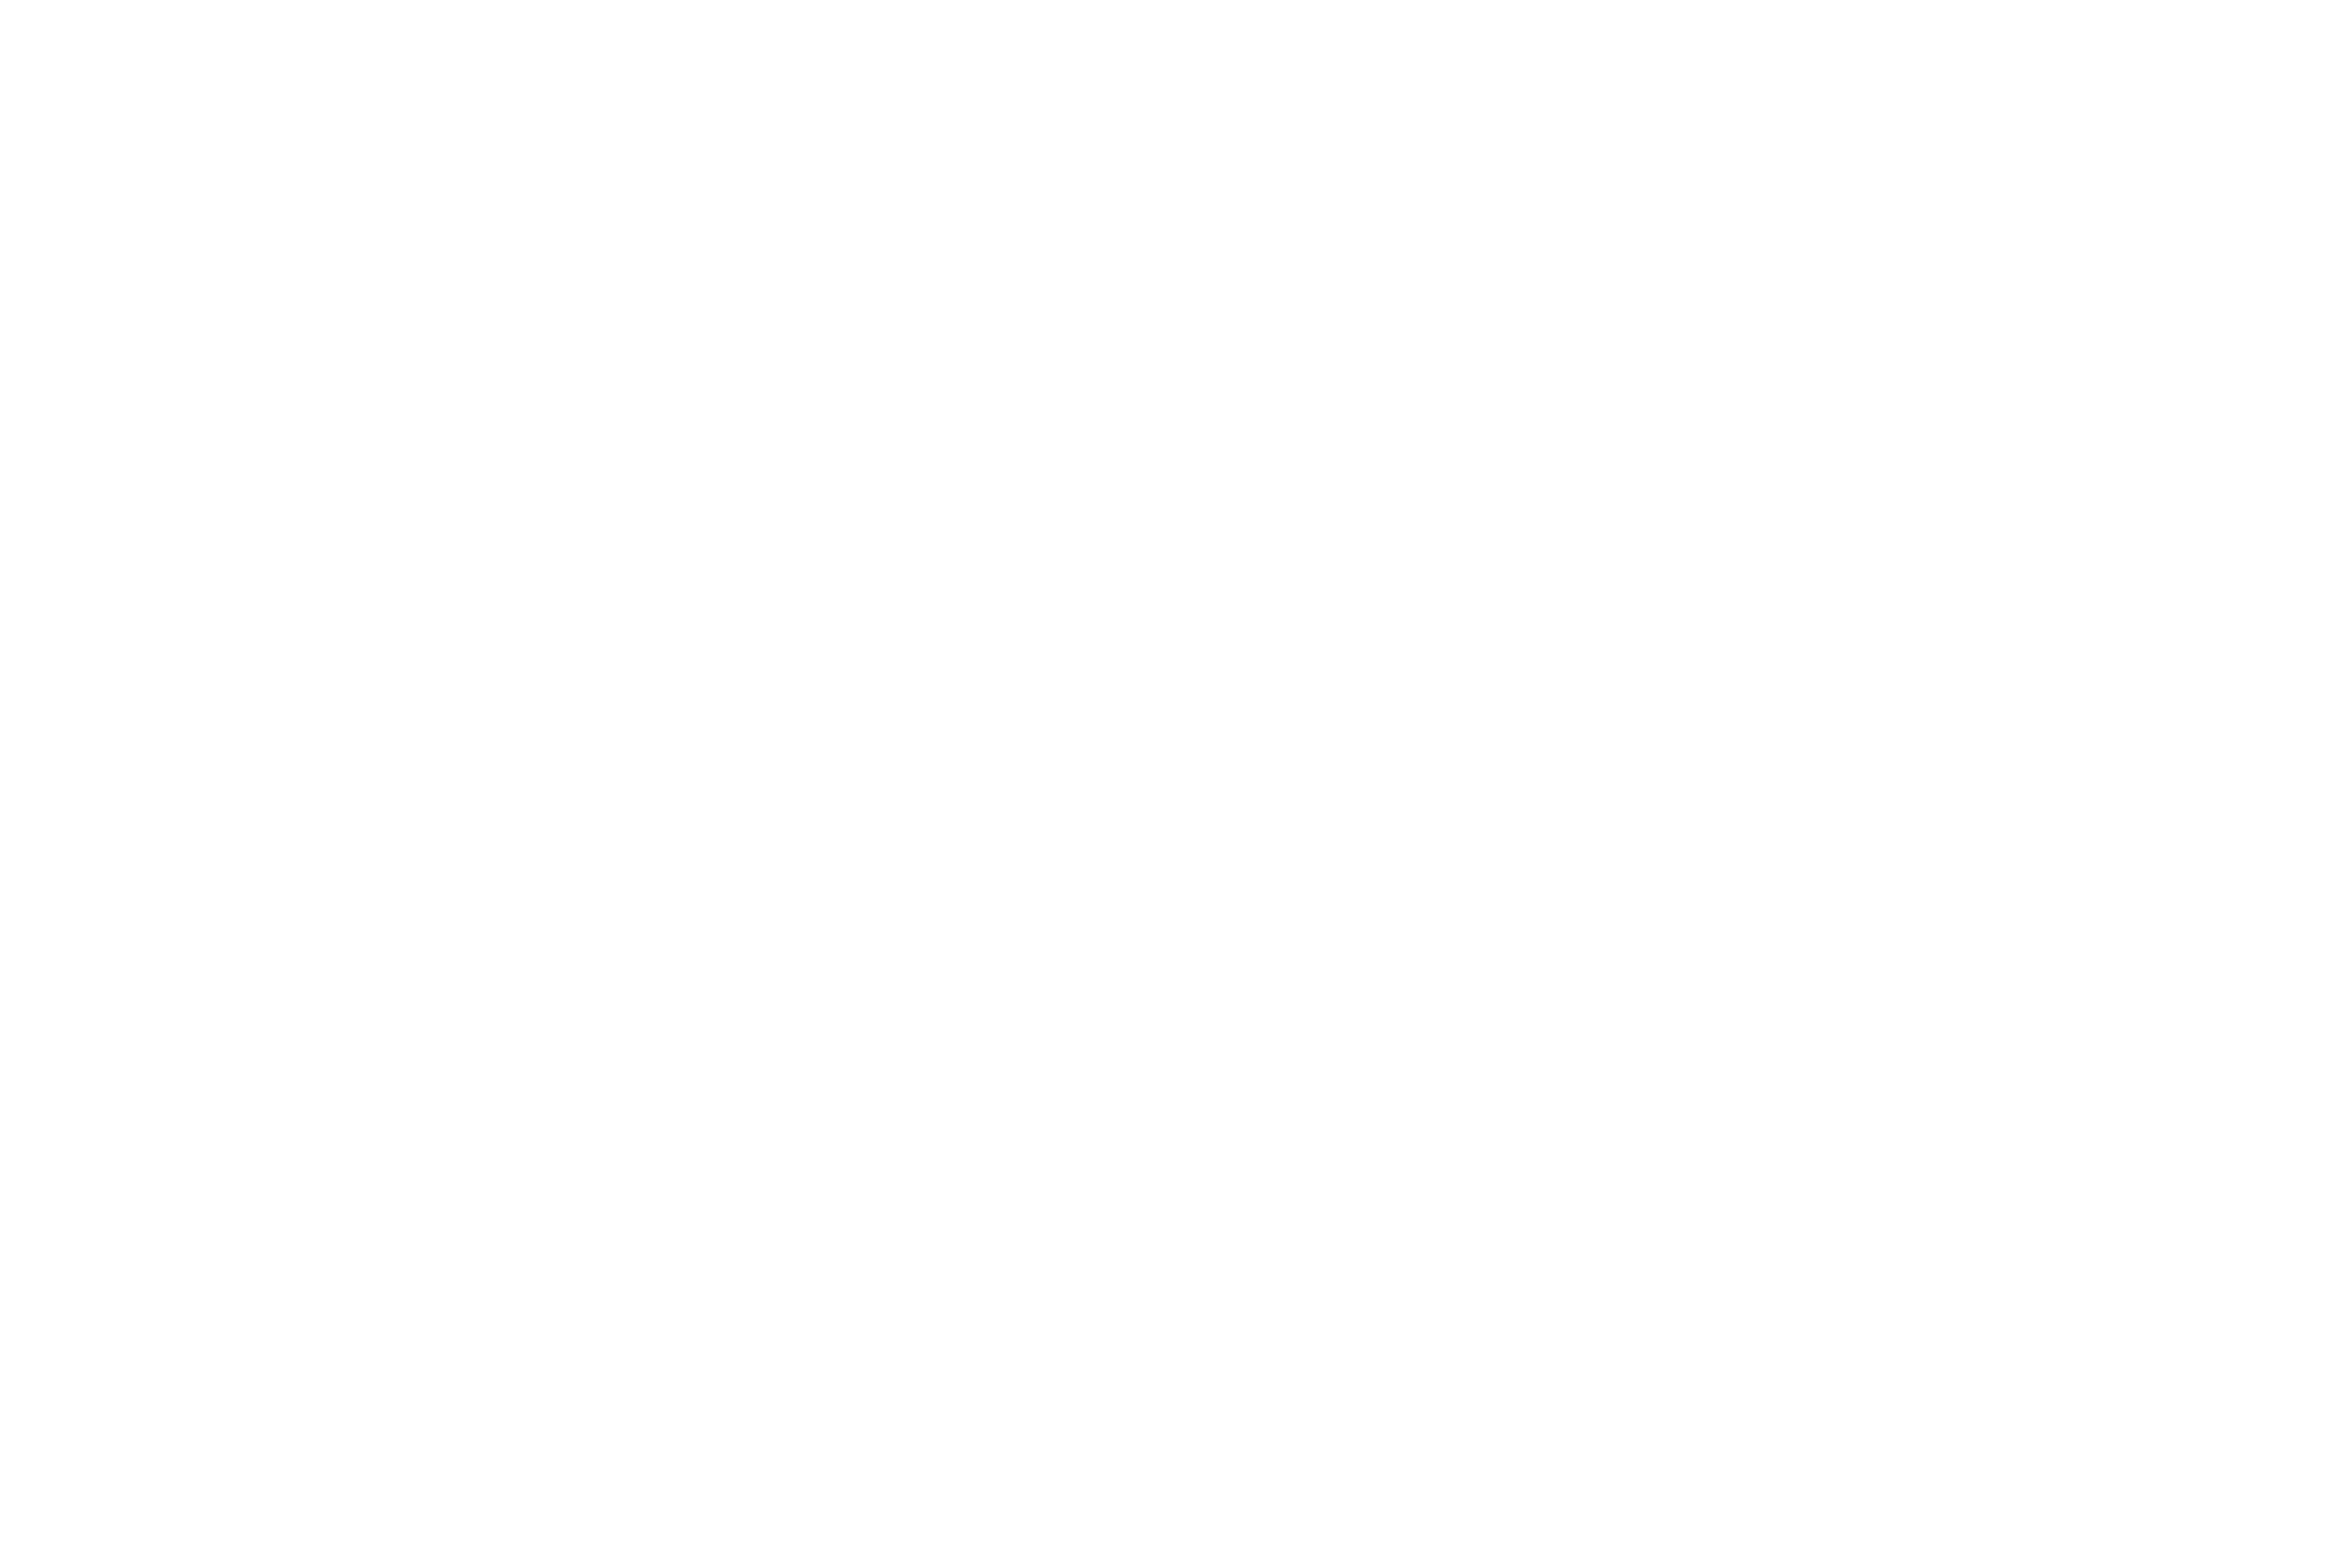

----

The chart now correctly displays a stacked bar chart of the 2024 Olympics medal tally for the top 10 countries. The x-axis represents the countries, and the y-axis represents the number of medals. Each country has a single bar, stacked with the number of gold, silver, and bronze medals they won. The colors used are gold, silver, and bronze, respectively. The chart is titled "2024 Olympics Medal Tally (Top 10 Countries)". The x-axis labels are rotated for better readability.


----

In [13]:
config_with_code = types.GenerateContentConfig(
    tools=[types.Tool(code_execution=types.ToolCodeExecution())],
    temperature=0.0,
)

response = chat.send_message(
    message="Now plot this as a seaborn chart. Break out the medals too.",
    config=config_with_code,
)

show_response(response)

## Further reading

When using search grounding, there are some specific requirements that you must follow, including when and how to show search suggestions, and how to use the grounding links.  Be sure to read and follow the details in the [search grounding capability guide](https://ai.google.dev/gemini-api/docs/grounding) and the [search suggestions guide](https://ai.google.dev/gemini-api/docs/grounding/search-suggestions).

Also check out some more compelling examples of using search grounding with the Live API in the [cookbook](https://github.com/google-gemini/cookbook/), like [this example that uses Google Maps to plot Search results on a map](https://github.com/google-gemini/cookbook/blob/main/examples/LiveAPI_plotting_and_mapping.ipynb) in an audio conversation, or [this example](https://github.com/google-gemini/cookbook/blob/main/examples/Search_grounding_for_research_report.ipynb) that builds a comprehensive research report.

*- [Mark McD](https://linktr.ee/markmcd)*